## Define different types of users
Active versus inactive 

0 versus 1

First hypothesis:
- you are inactive if you have less than 5 trips in two months

Second hypothesis:
- you are inactive if you have less than 50 miles in two months

### We have comb through everyone and determine whether they are active or inactive 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

/Users/samuelhuang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# create dataframes
driver = pd.read_csv("driver_ids.csv")
rider = pd.read_csv("ride_ids.csv")
timestamps = pd.read_csv("ride_timestamps.csv")

In [3]:
driver.head()

,driver_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,2016-03-29 00:00:00
1,007f0389f9c7b03ef97098422f902e62,2016-03-29 00:00:00
2,011e5c5dfc5c2c92501b8b24d47509bc,2016-04-05 00:00:00
3,0152a2f305e71d26cc964f8d4411add9,2016-04-23 00:00:00
4,01674381af7edd264113d4e6ed55ecda,2016-04-29 00:00:00


In [4]:
rider.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100


In [5]:
timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


## Cleaning the rider df
- durations into minutes 
- distance into miles 
- fare based on minutes
- fare based on distance
- Actual total fare

In [6]:
# Convert the seconds into mintues 
rider['duration_min'] = rider['ride_duration'].apply(lambda x: x / 60)

In [7]:
# Convert meters into miles 
rider['distance_mi'] = rider['ride_distance'].apply(lambda x: x *  0.00062137)

In [8]:
# The fare purely based on the length in minutes 
rider['fare_duration'] = rider['duration_min'].apply(lambda x: x * .22)

In [9]:
# The fare purely based on the distance 
rider['fare_distance'] = rider['distance_mi'].apply(lambda x: x * 1.15)

In [10]:
# Fare based on the formula presented online
rider['total_fare'] = ((rider['fare_distance'] + rider['fare_duration']) * (1 + (0.01 * rider['ride_prime_time']))) + 2 + 1.75


In [11]:
# Set minimum and maximum on the fares 
rider['total_fare'] = rider['total_fare'].apply(lambda x: x if x >= 5 else 5)
rider['total_fare'] = rider['total_fare'].apply(lambda x: x if x <= 400 else 400)

In [12]:
rider.head()

,driver_id,ride_id,ride_distance,ride_duration,ride_prime_time,duration_min,distance_mi,fare_duration,fare_distance,total_fare
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,1811,327,50,5.450000,1.125301,1.199000,1.294096,7.489644
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,3362,809,0,13.483333,2.089046,2.966333,2.402403,9.118736
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,3282,572,0,9.533333,2.039336,2.097333,2.345237,8.192570
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,65283,3338,25,55.633333,40.564898,12.239333,46.649632,77.361207
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,4115,823,100,13.716667,2.556938,3.017667,2.940478,15.666290


## Combining timestamp and onboarding dates 


In [13]:
timestamps.head()

,ride_id,event,timestamp
0,00003037a262d9ee40e61b5c0718f7f0,requested_at,2016-06-13 09:39:19
1,00003037a262d9ee40e61b5c0718f7f0,accepted_at,2016-06-13 09:39:51
2,00003037a262d9ee40e61b5c0718f7f0,arrived_at,2016-06-13 09:44:31
3,00003037a262d9ee40e61b5c0718f7f0,picked_up_at,2016-06-13 09:44:33
4,00003037a262d9ee40e61b5c0718f7f0,dropped_off_at,2016-06-13 10:03:05


In [14]:
# pivot the timestamps
pivot_timestamps = timestamps.pivot(index='ride_id', columns='event', values='timestamp')
pivot_timestamps.count()

event
accepted_at       194081
arrived_at        194080
dropped_off_at    194081
picked_up_at      194081
requested_at      194081
dtype: int64

In [15]:
# Preview the rides and the time stamp of each action 
pivot_timestamps.head()

event,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at
ride_id,,,,,
00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19
00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21
000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09
00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:40:47,2016-05-11 19:35:15,2016-05-11 19:29:36
0000d9b24d8ccdd991b76258e616fa01,2016-04-26 18:12:15,2016-04-26 18:16:52,2016-04-26 18:24:14,2016-04-26 18:16:55,2016-04-26 18:11:38


## This contains three crucial elements 
- driver_id
- ride_id
- driver_onboarding_date

In [16]:
# Merge driver_id, ride_id, and onboarding_date
driver_rider = pd.merge(rider[['driver_id','ride_id']], driver, on = 'driver_id', how = 'inner')
driver_rider.head()

,driver_id,ride_id,driver_onboard_date
0,002be0ffdc997bd5c50703158b7c2491,006d61cf7446e682f7bc50b0f8a5bea5,2016-03-29 00:00:00
1,002be0ffdc997bd5c50703158b7c2491,01b522c5c3a756fbdb12e95e87507eda,2016-03-29 00:00:00
2,002be0ffdc997bd5c50703158b7c2491,029227c4c2971ce69ff2274dc798ef43,2016-03-29 00:00:00
3,002be0ffdc997bd5c50703158b7c2491,034e861343a63ac3c18a9ceb1ce0ac69,2016-03-29 00:00:00
4,002be0ffdc997bd5c50703158b7c2491,034f2e614a2f9fc7f1c2f77647d1b981,2016-03-29 00:00:00


In [17]:
# merged the two data frames 
timestamps_driver = pd.merge(pivot_timestamps,driver_rider, on = 'ride_id', how = 'inner')
timestamps_driver.head()

,ride_id,accepted_at,arrived_at,dropped_off_at,picked_up_at,requested_at,driver_id,driver_onboard_date
0,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 10:03:05,2016-06-13 09:44:33,2016-06-13 09:39:19,d967f5296732fa55266b5f1314e7447b,2016-04-09 00:00:00
1,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:34:17,2016-05-14 05:26:18,2016-05-14 05:23:21,0656192a402808805282e60761bda088,2016-04-30 00:00:00
2,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:54:18,2016-05-16 15:47:32,2016-05-16 15:43:09,c468a648519cd42da75e6aa9dadf733e,2016-04-01 00:00:00
3,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:40:47,2016-05-11 19:35:15,2016-05-11 19:29:36,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04 00:00:00
4,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:59:26,2016-05-31 15:46:23,2016-05-31 15:44:56,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28 00:00:00


In [18]:
# Reorder the columns
timestamps_driver = timestamps_driver[['driver_id', 'driver_onboard_date', 'ride_id','requested_at', 'accepted_at', 'arrived_at', 'picked_up_at', 'dropped_off_at']]
timestamps_driver.head()#['driver_onboard_date'][0]

,driver_id,driver_onboard_date,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,d967f5296732fa55266b5f1314e7447b,2016-04-09 00:00:00,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,0656192a402808805282e60761bda088,2016-04-30 00:00:00,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,c468a648519cd42da75e6aa9dadf733e,2016-04-01 00:00:00,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04 00:00:00,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28 00:00:00,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:56,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:46:23,2016-05-31 15:59:26


In [19]:
# Create a new dataframe  
timestamps_driver_datetime = pd.DataFrame()


# Change them into timestamp dates 
timestamps_driver_datetime['driver_id'] = timestamps_driver['driver_id']

timestamps_driver_datetime['driver_onboard_date'] = pd.to_datetime(timestamps_driver['driver_onboard_date'])

timestamps_driver_datetime['ride_id'] = timestamps_driver['ride_id']

timestamps_driver_datetime['requested_at'] = pd.to_datetime(timestamps_driver['requested_at'])

timestamps_driver_datetime['accepted_at'] = pd.to_datetime(timestamps_driver['accepted_at'])

timestamps_driver_datetime['arrived_at'] = pd.to_datetime(timestamps_driver['arrived_at'])

timestamps_driver_datetime['picked_up_at'] = pd.to_datetime(timestamps_driver['picked_up_at'])

timestamps_driver_datetime['dropped_off_at'] = pd.to_datetime(timestamps_driver['dropped_off_at'])


timestamps_driver_datetime.head()

,driver_id,driver_onboard_date,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,d967f5296732fa55266b5f1314e7447b,2016-04-09,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,0656192a402808805282e60761bda088,2016-04-30,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,c468a648519cd42da75e6aa9dadf733e,2016-04-01,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:56,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:46:23,2016-05-31 15:59:26


,driver_id,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
driver_onboard_date,,,,,,,
2016-03-28,3849,3849,3849,3849,3849,3849,3849
2016-03-29,6937,6937,6937,6937,6936,6937,6937
2016-03-30,6001,6001,6001,6001,6001,6001,6001
2016-03-31,7199,7199,7199,7199,7199,7199,7199
2016-04-01,3294,3294,3294,3294,3294,3294,3294


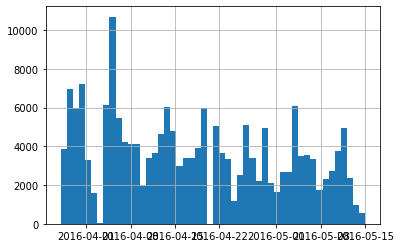

In [20]:
#timestamps_driver_datetime[timestamps_driver_datetime['driver_id'] == 'd967f5296732fa55266b5f1314e7447b'].count()

hist = timestamps_driver_datetime['driver_onboard_date'].hist(bins=50)

onboarding_amount = timestamps_driver_datetime.groupby(['driver_onboard_date']).count()
onboarding_amount.head()

In [21]:
# create a new data frame to contain frequency of riders 
df = pd.DataFrame()

df = rider.groupby(['driver_id'], as_index=False).size()

df = df.to_frame().reset_index()
df = df.rename(columns= {0: 'rides'})
df.head()

,driver_id,rides
0,002be0ffdc997bd5c50703158b7c2491,277
1,007f0389f9c7b03ef97098422f902e62,31
2,011e5c5dfc5c2c92501b8b24d47509bc,34
3,0152a2f305e71d26cc964f8d4411add9,191
4,01674381af7edd264113d4e6ed55ecda,375


In [22]:
# Create a dictionary of all the drivers as the key and the list of dates as a value
driver_ridedates = {}
for driver_id in df['driver_id']:
    # This is the dataframe with all the rides of a particular rider 
    temp_ride = timestamps_driver_datetime[timestamps_driver_datetime['driver_id'] == driver_id]
    
    #print(temp_ride.head())
    if temp_ride.shape[0] == 0:
        driver_ridedates[driver_id] = ['empty']
    elif temp_ride.shape[0] != 0:
        driver_ridedates[driver_id] = [temp_ride['driver_onboard_date'].tolist()[0]]
        driver_ridedates[driver_id].append(temp_ride['picked_up_at'].tolist())
        driver_ridedates[driver_id][1].sort()


In [23]:
driver_ridedates['056175954c78be4c4de7e80167b7e1f9']




['empty']

In [24]:
# The boolean is based on whether they had at least 5 rides per week average
# False means they didn't have enough 
# True means they reached the 5 rides a week quota 

driver_status = {}
for driver_id in df['driver_id']:
    if driver_ridedates[driver_id] == ['empty']:
        driver_status[driver_id] = False
    else:     
        driver_status[driver_id] = ((abs(driver_ridedates[driver_id][0] 
                                         - driver_ridedates[driver_id][1][-1])/7)*5).days <= len(driver_ridedates[driver_id][1])

        

In [25]:
# This just shows the amount of days between the initial onboarding and the last ride they accepted

driver_status_distance = {}
for driver_id in df['driver_id']:
    if driver_ridedates[driver_id] == ['empty']:
        driver_status_distance[driver_id] = 0
    else:     
        driver_status_distance[driver_id] = ((abs(driver_ridedates[driver_id][0] 
                                         - driver_ridedates[driver_id][1][-1]))).days 

In [26]:
#list(driver_status_distance.values())
#list(driver_status_distance)



In [27]:
driver_status_df = pd.DataFrame()

driver_status_df['driver_id'] = list(driver_status)

driver_status_df['driver_status'] = list(driver_status.values())

driver_status_df.head()

,driver_id,driver_status
0,002be0ffdc997bd5c50703158b7c2491,True
1,007f0389f9c7b03ef97098422f902e62,False
2,011e5c5dfc5c2c92501b8b24d47509bc,False
3,0152a2f305e71d26cc964f8d4411add9,True
4,01674381af7edd264113d4e6ed55ecda,True


In [28]:
driver_status_distance_df = pd.DataFrame()

driver_status_distance_df['driver_id'] = list(driver_status_distance)

driver_status_distance_df['driver_lifespan'] = list(driver_status_distance.values())

driver_status_distance_df.head()

,driver_id,driver_lifespan
0,002be0ffdc997bd5c50703158b7c2491,86
1,007f0389f9c7b03ef97098422f902e62,85
2,011e5c5dfc5c2c92501b8b24d47509bc,68
3,0152a2f305e71d26cc964f8d4411add9,64
4,01674381af7edd264113d4e6ed55ecda,56


timestamps_driver.count()

In [27]:
timestamps_driver.head()

,driver_id,driver_onboard_date,ride_id,requested_at,accepted_at,arrived_at,picked_up_at,dropped_off_at
0,d967f5296732fa55266b5f1314e7447b,2016-04-09 00:00:00,00003037a262d9ee40e61b5c0718f7f0,2016-06-13 09:39:19,2016-06-13 09:39:51,2016-06-13 09:44:31,2016-06-13 09:44:33,2016-06-13 10:03:05
1,0656192a402808805282e60761bda088,2016-04-30 00:00:00,00005eae40882760d675da5effb89ae3,2016-05-14 05:23:21,2016-05-14 05:23:25,2016-05-14 05:26:17,2016-05-14 05:26:18,2016-05-14 05:34:17
2,c468a648519cd42da75e6aa9dadf733e,2016-04-01 00:00:00,000061d42cf29f73b591041d9a1b2973,2016-05-16 15:43:09,2016-05-16 15:43:14,2016-05-16 15:47:29,2016-05-16 15:47:32,2016-05-16 15:54:18
3,689bdf87fb2de49f98bf4946cfaa5068,2016-04-04 00:00:00,00006efeb0d5e3ccad7d921ddeee9900,2016-05-11 19:29:36,2016-05-11 19:29:43,2016-05-11 19:35:11,2016-05-11 19:35:15,2016-05-11 19:40:47
4,eece82fe623b4bb335a9b9e20eb0ca54,2016-04-28 00:00:00,00012759befd5d34a0609800f6a1ee59,2016-05-31 15:44:56,2016-05-31 15:45:05,2016-05-31 15:46:22,2016-05-31 15:46:23,2016-05-31 15:59:26


## Use survival analytics to predict lifetime

In [30]:
driver_status_df.head()

,driver_id,driver_status
0,002be0ffdc997bd5c50703158b7c2491,True
1,007f0389f9c7b03ef97098422f902e62,False
2,011e5c5dfc5c2c92501b8b24d47509bc,False
3,0152a2f305e71d26cc964f8d4411add9,True
4,01674381af7edd264113d4e6ed55ecda,True


In [56]:
#lambda x: 1 if x == False else 0

In [57]:
driver_status_df['driver_status_bool'] = driver_status_df['driver_status'].apply(lambda x: 1 if x == False else 0)

In [58]:
driver_status_df.head()

,driver_id,driver_status,driver_status_bool
0,002be0ffdc997bd5c50703158b7c2491,True,0
1,007f0389f9c7b03ef97098422f902e62,False,1
2,011e5c5dfc5c2c92501b8b24d47509bc,False,1
3,0152a2f305e71d26cc964f8d4411add9,True,0
4,01674381af7edd264113d4e6ed55ecda,True,0


In [59]:
driver_status_distance_df.head()

,driver_id,driver_distance
0,002be0ffdc997bd5c50703158b7c2491,86
1,007f0389f9c7b03ef97098422f902e62,85
2,011e5c5dfc5c2c92501b8b24d47509bc,68
3,0152a2f305e71d26cc964f8d4411add9,64
4,01674381af7edd264113d4e6ed55ecda,56


In [60]:
# Survival Analysis Data Frame  
survival_dataframe = pd.merge(driver_status_df,driver_status_distance_df, on = 'driver_id', how = 'inner')

survival_dataframe.head()

,driver_id,driver_status,driver_status_bool,driver_distance
0,002be0ffdc997bd5c50703158b7c2491,True,0,86
1,007f0389f9c7b03ef97098422f902e62,False,1,85
2,011e5c5dfc5c2c92501b8b24d47509bc,False,1,68
3,0152a2f305e71d26cc964f8d4411add9,True,0,64
4,01674381af7edd264113d4e6ed55ecda,True,0,56


In [61]:
from lifelines import KaplanMeierFitter


In [62]:
# create a kmf object
kmf = KaplanMeierFitter() 

In [64]:
# Fit the data into the model
kmf.fit(survival_dataframe['driver_distance'], survival_dataframe['driver_status_bool'],label='Kaplan Meier Estimate')

<lifelines.KaplanMeierFitter: fitted with 937 observations, 765 censored>

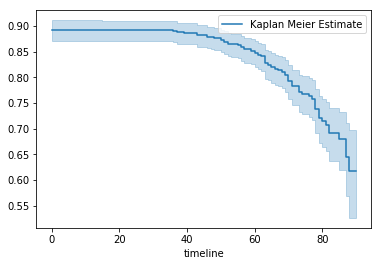

In [65]:
# Create an estimate
kmf.plot(ci_show=True) 



## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

In [67]:
survival_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 937 entries, 0 to 936
Data columns (total 4 columns):
driver_id             937 non-null object
driver_status         937 non-null bool
driver_status_bool    937 non-null int64
driver_distance       937 non-null int64
dtypes: bool(1), int64(2), object(1)
memory usage: 30.2+ KB


## Cox Proportional Hazard Model


In [68]:
from lifelines import CoxPHFitter
